## Calculate heat budget
using xgcm, and xgcm with metric and demonstrate budget closure

### Dask

In [1]:
%load_ext autoreload
%autoreload 2
# this is for when you do things on casper
import ncar_jobqueue
import dask
import distributed

cluster = ncar_jobqueue.NCARCluster() # initializes cluster
client = distributed.Client(cluster) 

cluster.adapt(minimum=6, maximum=32, wait_count=600) # gets you 6 workers minimum, max
                                                     # makes them wait 10 minutes before releasing
client

Client Scheduler: tcp://10.12.205.21:39159 Dashboard: /proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [2]:
%matplotlib inline

import xarray as xr
# from xgcm import Grid 
import numpy as np
import matplotlib.pyplot as plt
xr.set_options(display_style='html')
import pop_tools
from tqdm import tqdm

# get colorcycle
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']
import warnings
warnings.filterwarnings("ignore")
def pop_find_lat_ind(loc, LATDAT):
	return np.abs(LATDAT[:,0].values-loc).argmin()

def pop_find_lon_ind(loc, LONDAT, direction='w'):
	if direction.lower() in ['east', 'e']:
		value = loc
	elif direction.lower() in ['west','w']:
		value = 360 - loc
	else:
		print('I do not know which direction.')
	return np.nanargmin(np.abs(LONDAT[152,:].values-value))

def to_index(ds):
    ds = ds.copy()
    for dim in ds.dims:
        if dim in ["nlon_t", "nlat_t", "nlon_u", "nlat_u"]:
            ds = ds.drop(dim).rename({dim: dim[:-2]})
    return ds

def to_coord(ds, lon, lat):
    return ds.rename({"nlon": "nlon_" + lon,
                      "nlat": "nlat_" + lat})

def read_dat(files, variables, pop=False):
    def preprocess(ds):
        return ds[variables].reset_coords(drop=True) # reset coords means they are reset as variables

    ds = xr.open_mfdataset(files, parallel=True, preprocess=preprocess,
                           chunks={'time':1, 'nlon':400, 'nlat':-1},
                           combine='by_coords')
    if pop==True:
        file0 = xr.open_dataset(files[0])
        ds.update(file0[['ULONG', 'ULAT', 'TLONG', 'TLAT']])
        file0.close()

    ds
    return ds

# get pre calculated grid info --> you need DZT and DZU (not provided in output files)
# stencil files DZT and DZU
# dzt file
dzt_p = '/glade/work/deppenme/help_dir/'
dzt_f = 'Pac_dzt_t13.nc'
## dzu file
dzu_p = '/glade/work/deppenme/help_dir/'
dzu_f = 'Pac_DZU_t13.nc'
# get the infrastructure for the data, grid info and indices and such

ds_dzt = xr.open_dataset(dzt_p + dzt_f)
ds_dzu = xr.open_dataset(dzu_p + dzu_f) 

### Load Dataset

In [3]:
# %%time
# # load an example file from a tropical Pacific slice of heat budget terms, 
# # grid variables, and temperature and velocity terms

# pth = '/glade/p/cgd/oce/projects/JRA55/IAF/g.e20.G.TL319_t13.control.001_hfreq/ocn/proc/Pac_subdomain/'
# tstfile = 'Pac_g.e20.G.TL319_t13.control.001_hfreq.pop.h.0051-09-07.nc'

# # name variables you need to keep 
# varname=['TEND_TEMP','UET','VNT','WTT','HDIFN_TEMP','HDIFE_TEMP','DIA_IMPVF_TEMP',
#          'KPP_SRC_TEMP','SHF','SHF_QSW','hflux_factor','QSW_3D',
#          'TEMP','UVEL','VVEL','WVEL','HMXL',
#          'time','DXT','DYT','DXU','DYU','dz','dzw',
#          'TLONG','TLAT','ULONG','ULAT','TAREA','UAREA',
#          'KMT','z_t','z_w_top','z_w','z_w_bot', 'TEMP']

# # load dataset
# ds = xr.open_mfdataset(pth+tstfile, parallel=True, coords="minimal", data_vars="minimal", compat='override')
# # use only the variables you need, drop the rest 
# ds=ds.drop([v for v in ds.variables if v not in varname])
# ds

CPU times: user 412 ms, sys: 89.8 ms, total: 502 ms
Wall time: 35.3 s


<xarray.Dataset>
Dimensions:         (nlat: 305, nlon: 1301, time: 1, z_t: 62, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * time            (time) object 0051-09-08 00:00:00
  * z_t             (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * z_w             (z_w) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05 5.75e+05
  * z_w_top         (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot         (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG           (nlat, nlon) float64 dask.array<chunksize=(305, 1301), meta=np.ndarray>
    ULAT            (nlat, nlon) float64 dask.array<chunksize=(305, 1301), meta=np.ndarray>
    TLONG           (nlat, nlon) float64 dask.array<chunksize=(305, 1301), meta=np.ndarray>
    TLAT            (nlat, nlon) float64 dask.array<chunksize=(305, 1301), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables: (12/26)
    dz              (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    dzw             (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT             (nlat, nlon) float64 dask.array<chunksize=(305, 1301), meta=np.ndarray>
    UAREA           (nlat, nlon) float64 dask.array<chunksize=(305, 1301), meta=np.ndarray>
    TAREA           (nlat, nlon) float64 dask.array<chunksize=(305, 1301), meta=np.ndarray>
    DXU             (nlat, nlon) float64 dask.array<chunksize=(305, 1301), meta=np.ndarray>
    ...              ...
    WVEL            (time, z_w_top, nlat, nlon) float32 dask.array<chunksize=(1, 62, 305, 1301), meta=np.ndarray>
    UET             (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 305, 1301), meta=np.ndarray>
    VNT             (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 62, 305, 1301), meta=np.ndarray>
    WTT             (time, z_w_top, nlat, nlon) float32 dask.array<chunksize=(1, 62, 305, 1301), meta=np.ndarray>
    QSW_3D          (time, z_w_top, nlat, nlon) float32 dask.array<chunksize=(1, 62, 305, 1301), meta=np.ndarray>
    HMXL            (time, nlat, nlon) float32 dask.array<chunksize=(1, 305, 1301), meta=np.ndarray>
Attributes:
    title:             g.e20.G.TL319_t13.control.001_hfreq
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  day_5
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89091 2018-04-30 15:58:32Z altuntas@ucar...
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2019-01-28 at 05:50:25.2
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [ ]:
# this is for the version to be commited 
# open sample data
filepath = pop_tools.DATASETS.fetch('Pac_POP0.1_JRA_IAF_1993-12-6-test.nc')
ds = xr.open_dataset(filepath)

# get DZU and DZT, needed for operations later on
filepath_g = pop_tools.DATASETS.fetch('Pac_grid_pbc_1301x305x62.tx01_62l.2013-07-13.nc')
ds_g = xr.open_dataset(filepath_g)

ds["DZT"] = ds_g.DZT
ds["DZU"] = ds_g.DZU
ds["cell_volume_t"] = ds_g.DZT * ds_g.DXT * ds_g.DYT
ds["cell_volume_u"] = ds_g.DZU * ds_g.DXT * ds_g.DYT

#### if you wanted more than one file this is a convenient way to do it

In [4]:
# %%time
# import glob
# pth = '/glade/p/cgd/oce/projects/JRA55/IAF/g.e20.G.TL319_t13.control.001_hfreq/ocn/proc/Pac_subdomain/'
# sbd_fs = sorted(glob.glob(pth + 'Pac_g.e20.G.TL319_t13.control.001_hfreq.pop.h.0050-09-??.nc'))
# ds_more_than_one_file = read_dat(sbd_fs, varname, pop=True)
# ds_more_than_one_file

#### moving along

In [4]:
# get lola inds from somewhere for indexing later on
lola_inds = {}
inds_lat = [-8,-5,-4,-3,-2,-1,0,1,2,3,4,5,8]
for j in inds_lat:
    if j < 0:
        lola_inds['j_' + str(j)[1:] + 's'] = pop_find_lat_ind(j, ds.TLAT)
    else:
        lola_inds['j_' + str(j) + 'n'] = pop_find_lat_ind(j, ds.TLAT)
        
inds_lon = range(95,185,5)
for i in inds_lon:
    lola_inds['i_' + str(i) + '_w'] = pop_find_lon_ind(i, ds.TLONG)

#### just making sure everything works

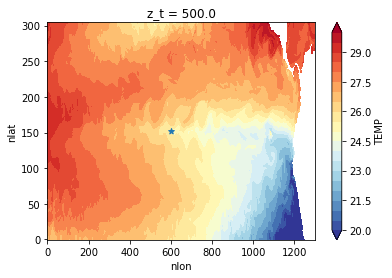

In [5]:
# just making sure everything works
ds.TEMP.isel(z_t=0).mean(dim='time').plot(levels=np.arange(20,30.5,0.5), cmap='RdYlBu_r')
plt.scatter(lola_inds['i_140_w'], lola_inds['j_0n'], marker='*')

#### set up vertical thickness and volume for scaling

In [6]:
ds['DZT'] = ds_dzt.DZT
ds['DZU'] = ds_dzu.DZU
ds.DZT.attrs['long_name'] = 'Thickness of T cells'
ds.DZT.attrs['units'] = 'centimeter'
ds.DZT.attrs['grid_loc'] = '3111'
ds.DZU.attrs['long_name'] = 'Thickness of U cells'
ds.DZU.attrs['units'] = 'centimeter'
ds.DZU.attrs['grid_loc'] = '3221'

VOL = (ds.DZT * ds.DXT* ds.DYT).compute()
KMT = ds.KMT.compute()

for j in tqdm(range(len(KMT.nlat))):
    for i in range(len(KMT.nlon)):
        k = KMT.values[j,i].astype(int)
        VOL.values[k:,j,i] = 0.

ds['VOL']=VOL

ds.VOL.attrs['long_name'] = 'volume of T cells'
ds.VOL.attrs['units'] = 'centimeter^3'

ds.VOL.attrs['grid_loc'] = '3111'

100%|██████████| 305/305 [00:01<00:00, 253.66it/s]


In [7]:
# here we get the xgcm compatible dataset 
gridx, dsx = pop_tools.to_xgcm_grid_dataset(ds)

# make sure we have the cell volumne for calculations
dsx["cell_volume"] = dsx.DZT * dsx.DXT * dsx.DYT

for coord in ['nlat', 'nlon']:
    if coord in dsx.coords:
        dsx = dsx.drop_vars(coord)

# this is necessary to make things multiply that otherwise would not        
if 'z_w_top' and 'z_w' in dsx.dims:
    dsx = dsx.drop('z_w_top').rename({'z_w': 'z_w_top'})
    
dsi = to_index(dsx)

#### Set up dataset to gather budget terms for xgcm (dx), and xgcm (dm) with metrics

In [8]:
dx = xr.Dataset()
dm = xr.Dataset()

## using xgcm 

#### 0) Tendency

In [9]:
dx['TEND_TEMP']=dsx.TEND_TEMP

#### i) Total heat advection

In [10]:
dx['UET'] = -( gridx.diff(to_coord((dsi.cell_volume * dsi.UET), 'u', 't'),
                   axis="X", boundary="extend")
              /
              dsx.cell_volume )

dx['VNT'] = -( gridx.diff(to_coord((dsi.cell_volume * dsi.VNT), 't', 'u'),
                   axis="Y", boundary="extend")
              /
              dsx.cell_volume )

dx['WTT'] = (gridx.diff((dsx.WTT.fillna(0) * dsx.dz.drop('z_t').rename({"z_t":"z_w_top"})
                        .assign_coords(z_w_top=dsx.z_w_top)), axis="Z", boundary="extend") 
             / 
             dsx.DZT)

dx['TOT_ADV']=dx['UET']+dx['VNT']+dx['WTT']

#### ii) Heat flux due to vertical mixing:
includes surface flux at the 0th layer

In [11]:
SRF_TEMP_FLUX = (dsx.SHF - dsx.SHF_QSW) * dsx.hflux_factor 
v_diffs = []
v_diff_0 = (SRF_TEMP_FLUX - dsx.DIA_IMPVF_TEMP.isel(z_w_bot=0)) / dsx.DZT.isel(z_t=0)
v_diffs.append(v_diff_0.drop(['z_w_bot', 'z_t']))

for k in range(1, 62):
    v = (dsx.DIA_IMPVF_TEMP.isel(z_w_bot=k-1) - dsx.DIA_IMPVF_TEMP.isel(z_w_bot=k)) / dsx.DZT.isel(z_t=k)
    v = v.drop(['z_t'])
    v_diffs.append(v)
v_diff_f = xr.concat(v_diffs, dim='z_t').chunk({'z_t': -1})
v_diff_f['z_t'] = dsx.z_t
dx['DIA_IMPVF_TEMP'] = v_diff_f

dx['KPP_SRC_TMP'] = dsx.KPP_SRC_TEMP

dx['VDIF'] = dx['DIA_IMPVF_TEMP']+dx['KPP_SRC_TMP']


#### iii) Heat flux due to horizontal diffusion

In [12]:
dx['HDIFE_TEMP'] = (gridx.diff(to_coord((dsi.cell_volume * dsi.HDIFE_TEMP), 'u', 't'),
                   axis="X", boundary="extend")/ dsx.cell_volume )
dx['HDIFN_TEMP'] = (gridx.diff(to_coord((dsi.cell_volume * dsi.HDIFN_TEMP), 't', 'u'),
                   axis="Y", boundary="extend")/ dsx.cell_volume )
dx['HDIF'] =dx['HDIFE_TEMP']+dx['HDIFN_TEMP']

#### iv) Solar penetration

In [13]:
dx['QSW_3D'] = (-gridx.diff((dsx.QSW_3D * dsx.hflux_factor), axis="Z", boundary="extend") 
         / dsx.DZT)

#### plot to check whether it closes

CPU times: user 2.36 s, sys: 1.91 s, total: 4.27 s
Wall time: 20.3 s


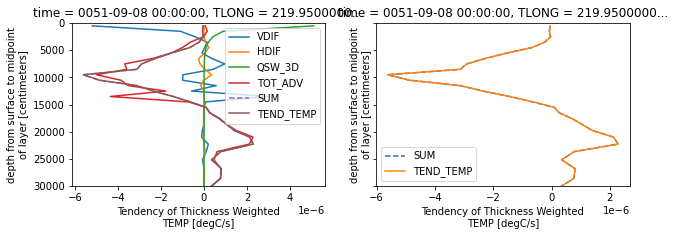

In [14]:
%%time

fig, ax = plt.subplots(1,2,figsize=(10,3), sharey=True)

# plot individual components
dx.VDIF.isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0).plot(y='z_t', ylim=(300e2,0),
                                                                                 label='VDIF', ax=ax[0])
dx.HDIF.isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0).plot(y='z_t', ylim=(300e2,0),
                                                                                 label='HDIF', ax=ax[0])
dx.QSW_3D.isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0).plot(y='z_t', ylim=(300e2,0),
                                                                                 label='QSW_3D', ax=ax[0])
dx.TOT_ADV.isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0).plot(y='z_t', ylim=(300e2,0),
                                                                                 label='TOT_ADV', ax=ax[0])

# plot sum 
((dx.QSW_3D + dx.HDIF + dx.VDIF + dx.TOT_ADV)
 .isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0)).plot(y='z_t', ylim=(300e2,0),
                                                                            label='SUM', ls='--', ax=ax[0])
# plot tendency
dx.TEND_TEMP.isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0).plot(y='z_t', ylim=(300e2,0),
                                                                                 label='TEND_TEMP', ax=ax[0])

ax[0].legend()

# plot sum 
((dx.QSW_3D + dx.HDIF + dx.VDIF + dx.TOT_ADV)
 .isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0)).plot(y='z_t', ylim=(300e2,0),
                                                                            label='SUM', ls='--', ax=ax[1])
dx.TEND_TEMP.isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0).plot(y='z_t', ylim=(300e2,0),
                                                                                 label='TEND_TEMP', ax=ax[1])

ax[1].legend()

## using xgcm with metrics

#### set grid and data set for xgcm with metrics

In [15]:
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"]}

gridxgcm, dsxgcm = pop_tools.to_xgcm_grid_dataset(ds, periodic=False, metrics=metrics)

#### 0) Tendency

In [16]:
dm['TEND_TEMP'] = dsxgcm.TEND_TEMP

#### i) Total heat advection

In [17]:
dm['UET'] = -(gridxgcm.diff(dsxgcm.UET * dsxgcm.VOL.values, axis="X", boundary="extend")
              /
              dsxgcm.VOL)
dm['VNT'] = -(gridxgcm.diff(dsxgcm.VNT * dsxgcm.VOL.values, axis="Y", boundary="extend")
              /
              dsxgcm.VOL)
dm['WTT'] = (gridxgcm.diff(dsxgcm.WTT.fillna(0) * (dsxgcm.dz * dsxgcm.DXT * dsxgcm.DYT).values,
                           axis="Z", boundary="extend")
             /
             dsxgcm.VOL)
dm['TOT_ADV'] = dm['UET'] + dm['VNT'] + dm['WTT']

#### ii) Heat flux due to vertical mixing:
includes surface flux at the 0th layer

In [18]:
dm['DIA_IMPVF_TEMP'] =  -(gridxgcm.diff(dsxgcm.DIA_IMPVF_TEMP * dsxgcm.TAREA, axis="Z", boundary="extend")
                           /
                           dsxgcm.VOL)
dm['DIA_IMPVF_TEMP'] = dm['DIA_IMPVF_TEMP'].load()

# set surface flux at 0th layer
SRF_TEMP_FLUX = (dsx.SHF - dsx.SHF_QSW) * dsx.hflux_factor 

dm['DIA_IMPVF_TEMP'][:,0,:,:]=((SRF_TEMP_FLUX * dsxgcm.TAREA  
                                -
                                dsxgcm.DIA_IMPVF_TEMP.isel(z_w_bot=0) * dsxgcm.TAREA)
                               /
                               dsxgcm.VOL.values[0,:,:])

dm['KPP_SRC_TMP'] = dsxgcm.KPP_SRC_TEMP
dm['VDIF'] = dm['DIA_IMPVF_TEMP'] + dm['KPP_SRC_TMP']

#### iii) Heat flux due to horizontal diffusion

In [19]:
dm['HDIFE_TEMP'] = (gridxgcm.diff(dsxgcm.HDIFE_TEMP * dsxgcm.VOL.values, axis="X", boundary="extend")
                    /
                    dsxgcm.VOL)
dm['HDIFN_TEMP'] = (gridxgcm.diff(dsxgcm.HDIFN_TEMP * dsxgcm.VOL.values, axis="Y", boundary="extend")
                    /
                    dsxgcm.VOL)
dm['HDIF'] = dm['HDIFE_TEMP'] + dm['HDIFN_TEMP']

#### iv) Solar Penetration

In [20]:
dm['QSW_3D'] = (-gridxgcm.diff((dsxgcm.QSW_3D * dsxgcm.hflux_factor), axis="Z", boundary="extend")
                /
                dsxgcm.DZT)

#### plot to make sure it closes

CPU times: user 3.32 s, sys: 5.01 s, total: 8.33 s
Wall time: 24.6 s


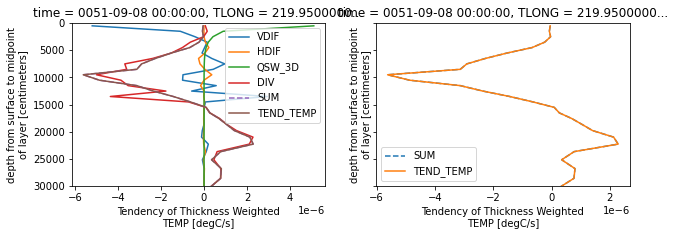

In [21]:
%%time

fig, ax = plt.subplots(1,2,figsize=(10,3), sharey=True)

# plot individual components
dm.VDIF.isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0).plot(y='z_t', ylim=(300e2,0),
                                                                                 label='VDIF', ax=ax[0])
dm.HDIF.isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0).plot(y='z_t', ylim=(300e2,0),
                                                                                 label='HDIF', ax=ax[0])
dm.QSW_3D.isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0).plot(y='z_t', ylim=(300e2,0),
                                                                                 label='QSW_3D', ax=ax[0])
dm.TOT_ADV.isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0).plot(y='z_t', ylim=(300e2,0),
                                                                                 label='DIV', ax=ax[0])

# plot sum 
((dm.QSW_3D + dm.HDIF + dm.VDIF + dm.TOT_ADV)
 .isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0)).plot(y='z_t', ylim=(300e2,0),
                                                                            label='SUM', ls='--', ax=ax[0])
# plot tendency
dm.TEND_TEMP.isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0).plot(y='z_t', ylim=(300e2,0),
                                                                                 label='TEND_TEMP', ax=ax[0])

ax[0].legend()

# plot sum 
((dm.QSW_3D + dm.HDIF + dm.VDIF + dm.TOT_ADV)
 .isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0)).plot(y='z_t', ylim=(300e2,0),
                                                                            label='SUM', ls='--', ax=ax[1])
# plot tendency
dm.TEND_TEMP.isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0).plot(y='z_t', ylim=(300e2,0),
                                                                                 label='TEND_TEMP', ax=ax[1])

ax[1].legend()

### Test Budget terms similarity across methods

CPU times: user 5.5 s, sys: 6.06 s, total: 11.6 s
Wall time: 33.4 s


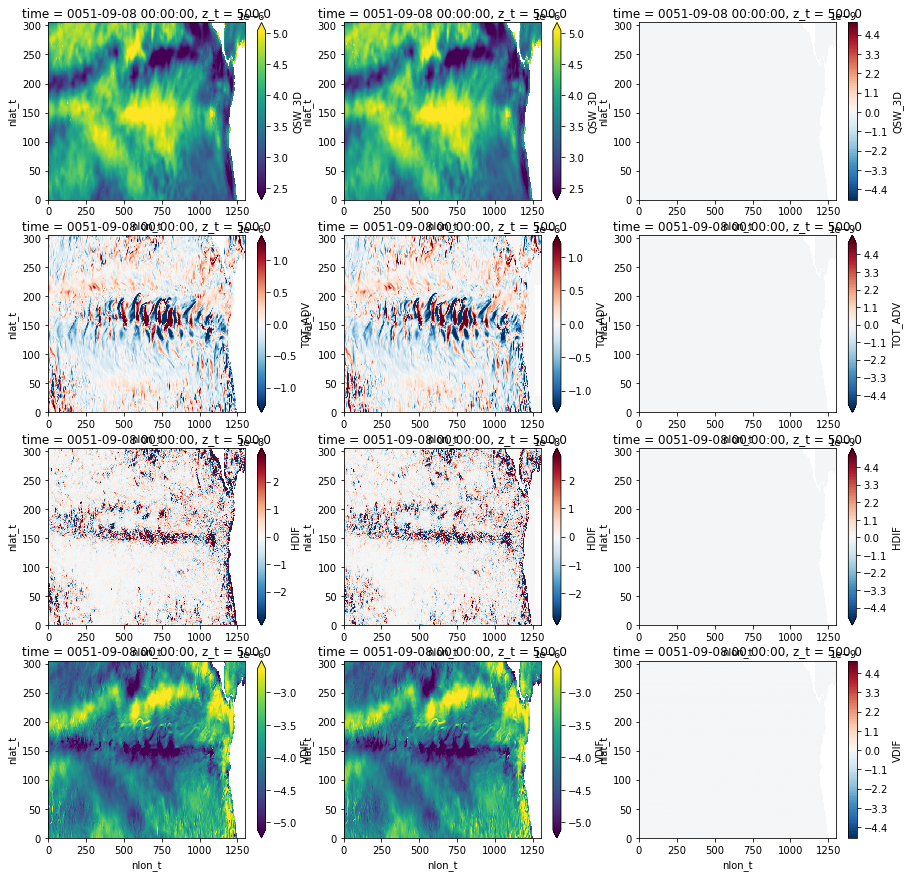

In [23]:
%%time

# test first layer
fig, ax = plt.subplots(4,3,figsize=(15,15))

# solar penetration
dm.QSW_3D.isel(time=0, z_t=0).plot(ax=ax[0,0], robust=True)
dx.QSW_3D.isel(time=0, z_t=0).plot(ax=ax[0,1], robust=True)

(dm.QSW_3D-dx.QSW_3D).isel(time=0, z_t=0).plot(ax=ax[0,2], levels=np.arange(-5e-9,5.1e-9,0.1e-9))

# total advection
dm.TOT_ADV.isel(time=0, z_t=0).plot(ax=ax[1,0], robust=True)
dx.TOT_ADV.isel(time=0, z_t=0).plot(ax=ax[1,1], robust=True)

(dm.TOT_ADV-dx.TOT_ADV).isel(time=0, z_t=0).plot(ax=ax[1,2], levels=np.arange(-5e-9,5.1e-9,0.1e-9))

# horizontal mixing
dm.HDIF.isel(time=0, z_t=0).plot(ax=ax[2,0], robust=True)
dx.HDIF.isel(time=0, z_t=0).plot(ax=ax[2,1], robust=True)

(dm.HDIF-dx.HDIF).isel(time=0, z_t=0).plot(ax=ax[2,2], levels=np.arange(-5e-9,5.1e-9,0.1e-9))

# vertical mixing
dm.VDIF.isel(time=0, z_t=0).plot(ax=ax[3,0], robust=True)
dx.VDIF.isel(time=0, z_t=0).plot(ax=ax[3,1], robust=True)

(dm.VDIF-dx.VDIF).isel(time=0, z_t=0).plot(ax=ax[3,2], levels=np.arange(-5e-9,5.1e-9,0.1e-9))


CPU times: user 5.51 s, sys: 6.05 s, total: 11.6 s
Wall time: 32.3 s


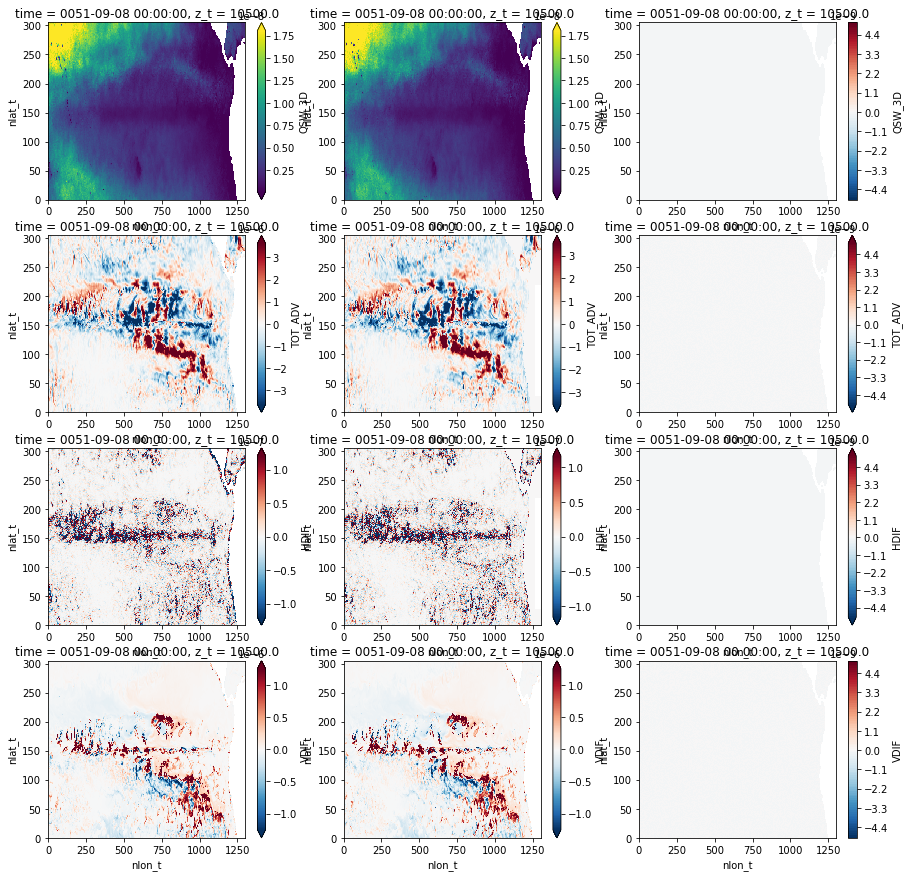

In [24]:
%%time

# test tenth layer
fig, ax = plt.subplots(4,3,figsize=(15,15))

# solar penetration
dm.QSW_3D.isel(time=0, z_t=10).plot(ax=ax[0,0], robust=True)
dx.QSW_3D.isel(time=0, z_t=10).plot(ax=ax[0,1], robust=True)

(dm.QSW_3D-dx.QSW_3D).isel(time=0, z_t=10).plot(ax=ax[0,2], levels=np.arange(-5e-9,5.1e-9,0.1e-9))

# total advection
dm.TOT_ADV.isel(time=0, z_t=10).plot(ax=ax[1,0], robust=True)
dx.TOT_ADV.isel(time=0, z_t=10).plot(ax=ax[1,1], robust=True)

(dm.TOT_ADV-dx.TOT_ADV).isel(time=0, z_t=10).plot(ax=ax[1,2], levels=np.arange(-5e-9,5.1e-9,0.1e-9))

# horizontal mixing
dm.HDIF.isel(time=0, z_t=10).plot(ax=ax[2,0], robust=True)
dx.HDIF.isel(time=0, z_t=10).plot(ax=ax[2,1], robust=True)

(dm.HDIF-dx.HDIF).isel(time=0, z_t=10).plot(ax=ax[2,2], levels=np.arange(-5e-9,5.1e-9,0.1e-9))

# vertical mixing
dm.VDIF.isel(time=0, z_t=10).plot(ax=ax[3,0], robust=True)
dx.VDIF.isel(time=0, z_t=10).plot(ax=ax[3,1], robust=True)

(dm.VDIF-dx.VDIF).isel(time=0, z_t=10).plot(ax=ax[3,2], levels=np.arange(-5e-9,5.1e-9,0.1e-9))


In [25]:
# You may need to install watermark (conda install -c conda-forge watermark)
%load_ext watermark
%watermark -d -iv -m -g -h
print('Above are the versions of the packages this works with.')

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1127.18.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 72
Architecture: 64bit

Hostname: casper12

Git hash: HEAD

ncar_jobqueue: 2020.3.4
dask         : 2021.2.0
numpy        : 1.19.5
xarray       : 0.17.0
distributed  : 2021.2.0
pop_tools    : 2020.9.14
matplotlib   : 3.2.2

Above are the versions of the packages this works with.
